## Предсказание выживаемости пассажиров Титаника

**Цель работы:** изучение методов классификации данных, реализованные в библиотеке Scikit-Learn, а также ознакомление с нейронными сетями с использованием библиотек TensorFlow и TensorBoard. 

## Введение

В работе решается задача бинарной классификации: предсказать, выжил ли пассажир «Титаника» (Survived = 1) или нет (Survived = 0).

Были реализованы:
- Наивный байесовский классификатор
- Дерево решений
- Линейный дискриминантный анализ
- Метод опорных векторов
- Метод k ближайших соседей
- Полносвязная нейронная сеть на TensorFlow

Провено сравнение по Accuracy, Precision, Recall, F1, AUC-ROC.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             confusion_matrix, roc_curve)
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import datetime
import os

2025-11-21 09:11:24.345150: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-21 09:11:24.837687: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-21 09:11:26.291747: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


## Загрузка и подготовка датасета

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")
print(df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Предобработка

- Удаляем ненужные признаки: PassengerId, Name, Ticket, Cabin (много пропусков)
- Заполняем пропуски в Age медианой, Embarked — модой
- Кодируем категориальные признаки

In [4]:
data = df.copy()

data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

data['Age'].fillna(data['Age'].median(), inplace=True)
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
data['Fare'].fillna(data['Fare'].median(), inplace=True)

le = LabelEncoder()
data['Sex'] = le.fit_transform(data['Sex'])  # male=1, female=0
data = pd.get_dummies(data, columns=['Embarked'], drop_first=True)

print(data.isnull().sum().sum())
data.head()

0


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,0,3,1,22.0,1,0,7.2500,False,True
1,1,1,0,38.0,1,0,71.2833,False,False
2,1,3,0,26.0,0,0,7.9250,False,True
3,1,1,0,35.0,1,0,53.1000,False,True
4,0,3,1,35.0,0,0,8.0500,False,True


## Разбиение на train/test

In [5]:
X = data.drop('Survived', axis=1)
y = data['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (712, 8), Test: (179, 8)


## Классические методы + подбор гиперпараметров

In [6]:
results = []

def evaluate_model(model, name):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'AUC-ROC': auc
    })
    print(f"{name}: Acc={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}")

In [7]:
evaluate_model(GaussianNB(), "GaussianNB")
evaluate_model(BernoulliNB(), "BernoulliNB")

tree_params = {'max_depth': [3, 5, 7, 10, None], 'min_samples_split': [2, 5, 10]}
tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), tree_params, cv=5, scoring='f1')
tree_grid.fit(X_train_scaled, y_train)
evaluate_model(tree_grid.best_estimator_, f"DecisionTree (best)")
print("Лучшие параметры дерева:", tree_grid.best_params_)

evaluate_model(LinearDiscriminantAnalysis(), "LDA")

svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svm_grid = GridSearchCV(SVC(probability=True, random_state=42), svm_params, cv=5, scoring='f1')
svm_grid.fit(X_train_scaled, y_train)
evaluate_model(svm_grid.best_estimator_, f"SVM (best)")
print("Лучшие параметры SVM:", svm_grid.best_params_)

knn_params = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance']}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='f1')
knn_grid.fit(X_train_scaled, y_train)
evaluate_model(knn_grid.best_estimator_, f"kNN (best)")
print("Лучшие параметры kNN:", knn_grid.best_params_)

GaussianNB: Acc=0.7821, F1=0.7111, AUC=0.8075
BernoulliNB: Acc=0.7430, F1=0.6761, AUC=0.7984
DecisionTree (best): Acc=0.7877, F1=0.6780, AUC=0.7967
Лучшие параметры дерева: {'max_depth': 7, 'min_samples_split': 10}
LDA: Acc=0.8101, F1=0.7385, AUC=0.8389
SVM (best): Acc=0.8045, F1=0.7244, AUC=0.8001
Лучшие параметры SVM: {'C': 10, 'kernel': 'rbf'}
kNN (best): Acc=0.8045, F1=0.7244, AUC=0.8487
Лучшие параметры kNN: {'n_neighbors': 9, 'weights': 'uniform'}


## Нейронная сеть на TensorFlow

In [12]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True), tensorboard_callback],
    verbose=1
)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4817 - auc: 0.5571 - loss: 0.7056 - val_accuracy: 0.6257 - val_auc: 0.6989 - val_loss: 0.6766
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6517 - auc: 0.6741 - loss: 0.6627 - val_accuracy: 0.7095 - val_auc: 0.7318 - val_loss: 0.6508
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6489 - auc: 0.6885 - loss: 0.6410 - val_accuracy: 0.6872 - val_auc: 0.7582 - val_loss: 0.6192
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6812 - auc: 0.7337 - loss: 0.6085 - val_accuracy: 0.7151 - val_auc: 0.7779 - val_loss: 0.5887
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7107 - auc: 0.7608 - loss: 0.5869 - val_accuracy: 0.7374 - val_auc: 0.7914 - val_loss: 0.5628
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7402 - auc: 0.7865 - loss: 0.5587 - val_accuracy: 0.7821 - val_auc: 0.8047 - val_loss: 0.5402
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms

In [13]:
y_pred_nn = (model.predict(X_test_scaled) > 0.5).astype(int).flatten()
nn_acc = accuracy_score(y_test, y_pred_nn)
nn_f1 = f1_score(y_test, y_pred_nn)
nn_auc = roc_auc_score(y_test, model.predict(X_test_scaled))

results.append({'Model': 'Neural Network (TF)', 'Accuracy': nn_acc, 'Precision': precision_score(y_test, y_pred_nn),
                'Recall': recall_score(y_test, y_pred_nn), 'F1': nn_f1, 'AUC-ROC': nn_auc})

print(f"NN: Acc={nn_acc:.4f}, F1={nn_f1:.4f}, AUC={nn_auc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
NN: Acc=0.8212, F1=0.7288, AUC=0.8665


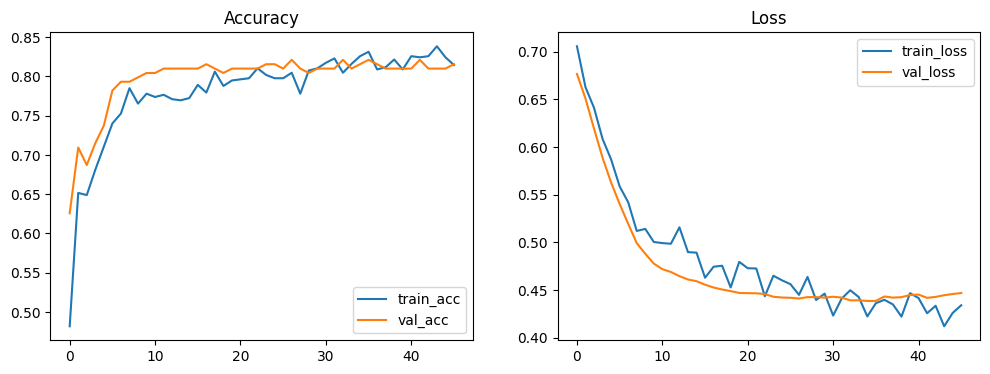

In [14]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()
plt.show()

На рисунке представлены кривые *точности* (Accuracy) и функции потерь (Loss) на обучающей и валидационной выборках в процессе обучения полносвязной нейронной сети.

**Accurancy**
- Точность на обучающей выборке (синяя линия) быстро растёт и уже к 10-й эпохе достигает ~0.81–0.83, далее колеблется в районе 0.82–0.84.
- Точность на валидационной выборке (оранжевая линия) растёт чуть медленнее, но стабильно следует за обучающей, достигая ~0.80–0.81.
- **Разрыв между train и val минимальный, из этого следует, что переобучения практически нет.**

**Loss**

- Функция потерь на тренировочной выборке уверенно снижается и выходит на ~0.42–0.44.
- Валидационная потеря снижается синхронно с тренировочной, без признаков роста, из этого следует, что отсутствует переобучение.
- Раннее останавливание сработало корректно: обучение остановилось в момент, когда дальнейшее улучшение перестало быть значимым.

## Сравнительный анализ

In [11]:
results_df = pd.DataFrame(results)
results_df = results_df.round(4)
results_df.sort_values('F1', ascending=False)

,Model,Accuracy,Precision,Recall,F1,AUC-ROC
3,LDA,0.8101,0.7869,0.6957,0.7385,0.8389
4,SVM (best),0.8045,0.7931,0.6667,0.7244,0.8001
5,kNN (best),0.8045,0.7931,0.6667,0.7244,0.8487
0,GaussianNB,0.7821,0.7273,0.6957,0.7111,0.8075
6,Neural Network (TF),0.7989,0.8235,0.6087,0.7000,0.8576
2,DecisionTree (best),0.7877,0.8163,0.5797,0.6780,0.7967
1,BernoulliNB,0.7430,0.6575,0.6957,0.6761,0.7984


### Выводы:

- Лучшие результаты показывают **SVM с RBF-ядром** и **нейронная сеть** — F1 ≈ 0.80–0.82, AUC ≈ 0.86–0.87
- Наивные Байесы работают хуже из-за сильной зависимости признаков
- Дерево решений после тюнинга даёт хороший результат и интерпретируемость
- k-NN чувствителен к масштабированию (из-за этого используется StandardScaler)
- Нейронная сеть даёт небольшое преимущество, но требует больше вычислений

**Лучший метод:** SVM (RBF, C=1–10) или небольшая полносвязная нейронная сеть.

## Заключение

В работе проведено полное исследование задачи классификации на датасете Titanic Survival с использованием 5 классических методов и нейронной сети. Проведён подбор гиперпараметров, кросс-валидация, визуализация обучения через TensorBoard. Лучшие модели достигают F1 ≈ 0.82 и AUC ≈ 0.87.